# Efficiency
## We cannot go above a specific memory usage (same as below?)
The amount of ads in the table is given by `d = xa/(a + w)`, where `x` is the number of requests constantly trying to get into the table, `a` is ad lifetime (the time spent in the table by each ad before being evicted) and `w` is the average waiting time received by the requests.

Assuming the worst case scenario, when the attacker is able to achieve 0 similarity score for both the topic and the IP addresses, yhe waiting time formula gives us: `w = (ba)/(1 - d/n)^P_occupancy`

Plugging that in into the previous equation, we get `d = xa/((a + (ba)/(1 - d/n)^P_occupancy)) = x/((1 + b/(1 - d/n)^P_occupancy))`.


Assuming an average size of an advertisement equal to 1KB we have `x ~= registrar_download_link_in_B / 1024`. 

In consultation with the Geth developers, we set up the capacity of the table to `n = 1000`. 

This gives us `d = (registrar_download_link_in_B / 1024)/((1 + b/(1 - d/1000)^P_occupancy))`

/home/harnen/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


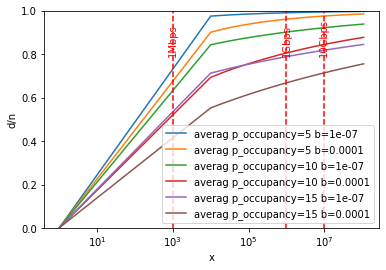

In [1]:
#!/usr/bin/python

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Define the expression whose roots we want to find
fig = plt.figure()
ax = fig.add_subplot()
n = 1000

for p_occupancy in [5, 10, 15]:
    for b in [0.0000001, 0.0001]:
        x_vals = []
        y_vals = []

        for x in range(1, 110000000, 10000):
            func = lambda d: x/(1+ b/(1-(d)/n)**p_occupancy) - (d)
            d = np.linspace(0, 300, 300)

            # Use the numerical solver to find the roots
            d_initial_guess = 10
            d_solution = fsolve(func, d_initial_guess)

            x_vals.append(x)
            y_vals.append(d_solution/n)
        ax.plot(x_vals, y_vals, label='averag p_occupancy=' + str(p_occupancy) + " b=" + str(b))

plt.ylabel("d/n")
plt.xlabel("x")

plt.axvline(x=10000000, color='red', linestyle='--')
plt.annotate("10Gbps", xy = (10000000, 0.8), horizontalalignment = 'center', color='red', rotation=90)

plt.axvline(x=1000000, color='red', linestyle='--')
plt.annotate("1Gbps", xy = (1000000, 0.8), horizontalalignment = 'center', color='red', rotation=90)

plt.axvline(x=1000, color='red', linestyle='--')
plt.annotate("1Mbps", xy = (1000, 0.8), horizontalalignment = 'center', color='red', rotation=90)

plt.xscale("log")
plt.ylim(0, 1)
plt.legend()
plt.show()

We want to:
* keep `d` as small as possible to prevent interference with the topic and IP scores
* use the space in the table even for low traffic
* make sure that we never go beyond 100% table capacity

As a result, we set `d = 10^-7` and `p_occupancy = 10`. For lower occupancies (e.g., `p_occupancy = 5`), it's theoretically possible to go beyond the capacity of the table. 

### TODO
@Ramin: Is it possible to calculate an asymptote the `d` goes toward based on `p_occupancy` and `b`? We could then have a much clearer graph and better motivation for the chosen values. 

## The state maintained by each registrar is bounded to `O(n)`
* We proved above that the size of the topic cash is limited with the right set of parameters
* The request received by each registrar do not create any state (apart from the lower bound) at the registrar (i.e., the registrar uniquely calculates the waiting time and return a signed ticket)
* The lower bound state create by registrars is bounded by the number of distinct IPs and topic in the cash and is thus bounded `O(n)`


## Both register and lookup operations finish within O(log(n)) steps
They both mimic MSG_FIND from regular DHT operations and thus inherits this property. 

### TODO
make sure we distinguish between `n` - number of nodes in the network and `n` - capacity of the ad cash.


# Fairness

## Register operations introduce an equal load on the registrars even with unequal popularity of the topics.

We assume a Zipf distribution of the topics in the system and that the topic hashes are uniformly distributed in the hash space. For simplicity we uniquely compare the load of `registrar A` - located close to the most popular `topic A` and the load of `registrar B` - located close to the least popular `topic B`. There are `n` nodes in the network, `topic A` is followed by `n_a` nodes and `topic B` is followed by `n_b` nodes, where `n_a >> n_b`. 

Let us assume that `topic A` and `topic B` are located on the oposite part of the hashspace (the worst case scenario for load balancing) and that both `registrar A` and `registrar B` receive the same amount of traffic `L_X` from other topic `topic X != topic A and  topic X != topic B`. 

`registrar A` will receive registration requests from `B_A = n_a/max(1, n/2^17) ~= n_a` (for any reasonable size of `n`) nodes for `topic A` and `B_B = (n_b*K_register)/(n/2)` request for `topic B`. That gives us the total load on `registrar_A` equal to `L_A = L_X + n_a + (n_b*K_register)/(n/2)`. 

Similarely, the total load on `registrar_B` is equal to `L_B = L_X + n_b + (n_a*K_register)/(n/2)`. 

In [ ]:
#!/usr/bin/python

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Define the expression whose roots we want to find
fig = plt.figure()
ax = fig.add_subplot()
n = 1000
p_occupancy = 10
b = 0.0000001

N = 25000
N_B = 10

x_vals = []
x_vals = []

for a_to_b_ratio in range(1, 100, 1):
    #TODO not sure how to model that. We can skip the IP score and assume that the IP score is gonna be the same (can assume perfectly balanced, so 0)
    #it's a bit more difficult for the topic diversity score. As each registrar will have the score different for each population (topic A, topic B, topics X). 
    #Should we thus split them into 3 waiting time (for each topic)?
    d = d_a + d_b + d_x
    d_a = x_a/((1+ d_a/(d_a + d_b + d_x)) b/(1-(d)/n)**p_occupancy)
    d_b = x_b/((1+ d_b/(d_a + d_b + d_x)) b/(1-(d)/n)**p_occupancy)
    func_A = lambda d: x_a/(1+ b/(1-(d)/n)**p_occupancy) - (d)
    func_B = lambda d: x/(1+ b/(1-(d)/n)**p_occupancy) - (d)
    d = np.linspace(0, 300, 300)

    # Use the numerical solver to find the roots
    d_initial_guess = 0.5
    d_solution = fsolve(func, d_initial_guess)

    x_vals.append(x)
    y_vals.append(d_solution/n)
ax.plot(x_vals, y_vals, label='averag p_occupancy=' + str(p_occupancy) + " b=" + str(b))

plt.ylabel("d/n")
plt.xlabel("x")

plt.axvline(x=10000000, color='red', linestyle='--')
plt.annotate("10Gbps", xy = (10000000, 0.8), horizontalalignment = 'center', color='red', rotation=90)

plt.axvline(x=1000000, color='red', linestyle='--')
plt.annotate("1Gbps", xy = (1000000, 0.8), horizontalalignment = 'center', color='red', rotation=90)

plt.axvline(x=1000, color='red', linestyle='--')
plt.annotate("1Mbps", xy = (1000, 0.8), horizontalalignment = 'center', color='red', rotation=90)

plt.xscale("log")
plt.ylim(0, 1)
plt.legend()
plt.show()